###TEAM MEMBERS:
Hesham Sherif (Data Scientist)

Mohamed Khaled (Machine Learning Engineer)

The main topic of these Notebook is single object detection, which means getting a model to draw a box around every key object in an image, and label each one correctly.  we can use transfer learning from an <b>ImageNet</b> classifier that was never even trained to do detection.We are going to follow these steps:
- Classify the biggest object
- Predict Bounding box of biggest object
- Put all together to predict and classify the biggest object

we’ll use a single model to do both these at the same time.

###upgrade and import some packages

In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-61g_5ee5
  Running command git clone -q https://github.com/keras-team/keras.git /tmp/pip-req-build-61g_5ee5
ERROR: File "setup.py" not found for legacy project git+https://github.com/keras-team/keras.git.


In [2]:
import keras
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

from google.colab.patches import cv2_imshow

## Pascal VOC
We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. later we can use the larger 2012 for better results.



In [3]:
import os
if not os.path.isdir('./VOCdevkit/'):
    ! wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    #! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    #! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
    #! rm -Rf VOCdevkit/VOC2007/PASCAL_VOC
    !unzip /content/pascal_train2007.json.zip
    
    !mv  /content/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json 
      

In [4]:
!unzip /content/pascal_train2007.json.zip
    
!mv  /content/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json 

Archive:  /content/pascal_train2007.json.zip
  inflating: pascal_train2007.json   


In [5]:
from pathlib import Path

PATH = Path('VOCdevkit/VOC2007/')
for i in PATH.iterdir(): print(i)
    
JPEGS = PATH/'JPEGImages'

VOCdevkit/VOC2007/SegmentationObject
VOCdevkit/VOC2007/ImageSets
VOCdevkit/VOC2007/JPEGImages
VOCdevkit/VOC2007/SegmentationClass
VOCdevkit/VOC2007/pascal_train2007.json
VOCdevkit/VOC2007/Annotations


so, you have:
- <kbd>JPEGImages</kbd> folder containing all the images
- <kbd>Annotations</kbd> folder containing all the annotation, one XML annotation file per image file

The original version were in XML, which is a little hard to work with nowadays, so we use the more recent JSON version

In [6]:
import json
BD = json.load((PATH/'pascal_train2007.json').open()) # it loads a dictionary
print('the dictionary of keys: ',BD.keys())

the dictionary of keys:  dict_keys(['images', 'type', 'annotations', 'categories'])


In [7]:
# Then, we can acces to the image
BD['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [8]:
# The annotations
BD['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [9]:
# and all category
BD['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

###show some images

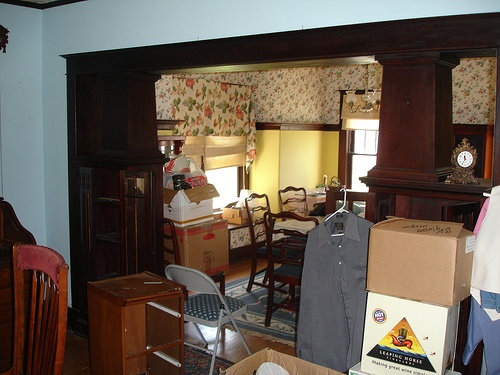

In [10]:
import cv2 
img=cv2.imread('VOCdevkit/VOC2007/JPEGImages/000005.jpg')
cv2_imshow(img)

In [11]:
import collections

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# we convert categories into dictionary
data_category = dict((o['id'],o['name']) for o in BD['categories']) # all the categories
data_filename = dict((o['id'],o['file_name']) for o in BD['images']) # image id to image filename
data_ids = [o['id'] for o in BD['images']] # list of all the image IDs

annotations = collections.defaultdict(lambda:[])
for o in BD['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = hw_bb(bb)
        annotations[o['image_id']].append((bb,o['category_id']))
        
print('we have',len(BD['annotations']),'annotations')

we have 7844 annotations


## some convenient display functions

In [12]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    """show images"""
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
  
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    """Draw rectangle around the object of interest"""
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    """Write the text on the upper right corner of rectangle surrounding the object"""
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)    
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8)) # That's why the image with draw_im is zoomed in
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)
        
def draw_idx(i):
    im_a = annotations[i]
    im = image.imread(JPEGS/data_filename[i])
    draw_im(im, im_a)    

###Use the preivious functions

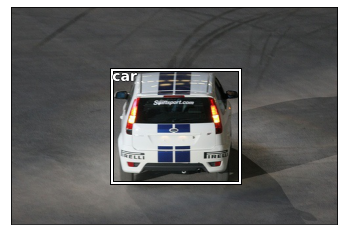

In [13]:
im = image.imread(JPEGS/data_filename[data_ids[0]])
    
ax = show_img(im)
bbox = annotations[data_ids[0]][0][0]
clas_id = annotations[data_ids[0]][0][1]
bbox = bb_hw(bbox)

draw_rect(ax, bbox)
draw_text(ax, bbox[:2], data_category[clas_id])    

## Step 1: Largest item classifier

We are going to create a classifier to predict the class of the biggest object in the image. 
For that purpose, we need to structure our learning data in a scalable manner as we will, step by step, increase the complexity of our task.

### Setup the data folder
___copy vs. point___

__Flow from directory means to copy__

So, there are plenty of way to do that, but in Fast.ai, they use a csv file to list all images/labels instead of creating a new directory and copying inside all the needed data. For sure, it sounds better than recreating a folder and copying all the need images and labels... not really convenient, neither scalable. And finally, they have this nice function to train directly from a CSV file. 

__Flow from dataframe__
In August 2018, Keras came with a super usefull function called <kbd>flow_from_dataframe</kbd>!!! Great, no more code to do, it is a method from <kbd>ImageDataGenerator</kbd>, and uses same properties, that is to say we can even do Data AUgmentation!

So, before doing anything with the data, that is to say jump to the conclusion, we have first to figure out how we will provide the data to our network. As we said before, Keras can use Dataframe to represent the data.

What do we put them in our dataframe? We want for each image to have a classification tag. Sounds pretty easy, right?

So,it's supposed to look like this

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/06_Single_Object_Detection/dataframe.png" width="30%">

Let's do it now!

In [14]:
import pandas as pd

def get_largest_annotation(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]


filename=[]
C=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    
    C.append(data_category[get_largest_annotation(annotation)[1]])
    
df = pd.DataFrame({'filename': filename, 'class': C}, columns=['filename','class'])

df[:5]

filename      class
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

### Split our data into training and validation set

In [15]:
# create a training and validation set

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))
    
    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))
    
    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

## Data augmentation
The easiest way to do Data Augmentation is to create an <kbd>ImageDataGenerator</kbd> and specify the transformation properties.  the data needs to be preprocessed to be compatible with the model used (VGG16). 

In [16]:
# our batch size
bs=32
# define the size of our input data
sz=224

# preprocess_input is for VGG16 in our case
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(df_train, # The df
                                                  JPEGS, # Place on desk
                                                  x_col='filename', # The column to get x
                                                  y_col='class', # The column to get y
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(df_valid, 
                                                  JPEGS, 
                                                  x_col='filename', 
                                                  y_col='class', 
                                                  has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=list(train_batches.class_indices), 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Found 1750 validated image filenames belonging to 20 classes.
Found 751 validated image filenames belonging to 20 classes.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

###  Create our model

it will be a VGG16 model.

In [17]:
net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
# we add our classification layer
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NbClasses, activation='softmax', name='softmax')(x)
model = Model(inputs=net.input, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###Define an optimizer and a Loss function

In [18]:
epochs = 20

opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


###It is time to train now

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
54/54 [==============================] - 41s 594ms/step - loss: 26.5072 - accuracy: 0.1857 - val_loss: 13.1355 - val_accuracy: 0.3981
Epoch 2/20
54/54 [==============================] - 28s 522ms/step - loss: 15.8841 - accuracy: 0.3562 - val_loss: 10.1926 - val_accuracy: 0.5353
Epoch 3/20
54/54 [==============================] - 28s 520ms/step - loss: 13.0565 - accuracy: 0.4703 - val_loss: 9.2823 - val_accuracy: 0.5842
Epoch 4/20
54/54 [==============================] - 28s 523ms/step - loss: 10.5215 - accuracy: 0.5221 - val_loss: 8.5532 - val_accuracy: 0.6359
Epoch 5/20
54/54 [==============================] - 29s 532ms/step - loss: 9.1692 - accuracy: 0.5658 - val_loss: 8.1835 - val_accuracy: 0.6359
Epoch 6/20
54/54 [==============================] - 28s 517ms/step - loss: 7.6028 - accuracy: 0.6129 - val_loss: 7.4927 - val_accuracy: 0.6658
Epoch 7/20
54/54 [==============================] - 28s 518ms/step - loss: 6.6083 - accuracy: 0.6647 - val_loss: 7.4960 - val_accuracy: 

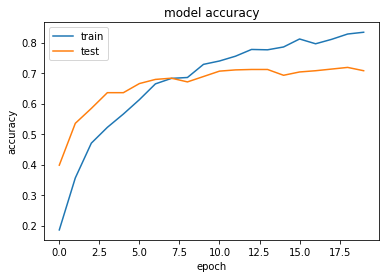

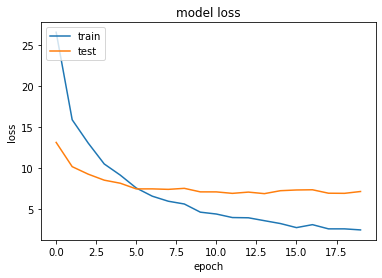

In [19]:
history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###unfreeze couple of layers for better learning and enhance the accuracy


In [20]:
#unfreeze initial layers
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###Train again

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
54/54 [==============================] - 30s 531ms/step - loss: 2.1477 - accuracy: 0.8359 - val_loss: 6.1346 - val_accuracy: 0.7065
Epoch 2/10
54/54 [==============================] - 29s 530ms/step - loss: 1.8602 - accuracy: 0.8277 - val_loss: 5.4272 - val_accuracy: 0.7106
Epoch 3/10
54/54 [==============================] - 28s 527ms/step - loss: 1.6241 - accuracy: 0.8411 - val_loss: 5.0424 - val_accuracy: 0.6997
Epoch 4/10
54/54 [==============================] - 29s 529ms/step - loss: 1.4688 - accuracy: 0.8353 - val_loss: 4.7073 - val_accuracy: 0.7052
Epoch 5/10
54/54 [==============================] - 29s 531ms/step - loss: 1.3229 - accuracy: 0.8347 - val_loss: 4.4152 - val_accuracy: 0.7092
Epoch 6/10
54/54 [==============================] - 29s 532ms/step - loss: 1.3324 - accuracy: 0.8318 - val_loss: 4.2544 - val_accuracy: 0.7106
Epoch 7/10
54/54 [==============================] - 29s 529ms/step - loss: 1.1184 - accuracy: 0.8504 - val_loss: 4.3773 - val_accuracy: 0.7188

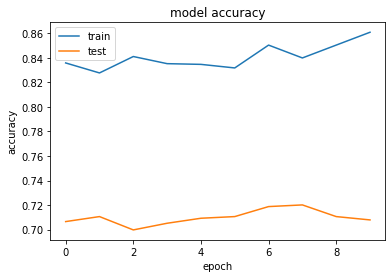

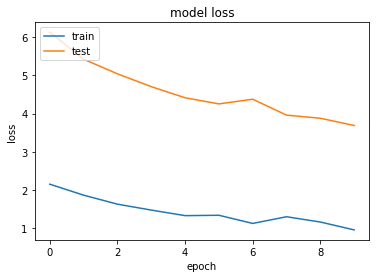

In [22]:
epochs = 10

opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Check the result
unprocess function is just to inverse what preprocess_fct or preprocess_input (of VGG for for example) dir. Like normalization (multiply by std and add back the mean), or clipping (*255 again)

In [23]:
def unpreprocess(x, data_format,mode):
    """unpreprocesses a Numpy array encoding a batch of images.
    # Arguments
        x: Input array, 3D or 4D.
        data_format: Data format of the image array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        unreprocessed Numpy array.
    """
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    im = np.copy(x) 

    if mode == 'tf':
        im += 1.
        im *= 127.5
        im = np.clip(im, 0, 255)
        return im.astype(np.uint8)

    if mode == 'torch':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if im.ndim == 3:
            if std is not None:
                im[0, :, :] *= std[0]
                im[1, :, :] *= std[1]
                im[2, :, :] *= std[2]
                
            im[0, :, :] += mean[0]
            im[1, :, :] += mean[1]
            im[2, :, :] += mean[2]

        else:
            if std is not None:
                im[:, 0, :, :] *= std[0]
                im[:, 1, :, :] *= std[1]
                im[:, 2, :, :] *= std[2]
                
            im[:, 0, :, :] += mean[0]
            im[:, 1, :, :] += mean[1]
            im[:, 2, :, :] += mean[2]

    else:
        if std is not None:
            im[..., 0] *= std[0]
            im[..., 1] *= std[1]
            im[..., 2] *= std[2]        
        im[..., 0] += mean[0]
        im[..., 1] += mean[1]
        im[..., 2] += mean[2]

    if mode == 'torch':
        im *= 255.
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if im.ndim == 3:
                im = im[::-1, ...]
            else:
                im = im[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            im = im[..., ::-1]
         
    im = np.clip(im, 0, 255)

    return im.astype(np.uint8) 

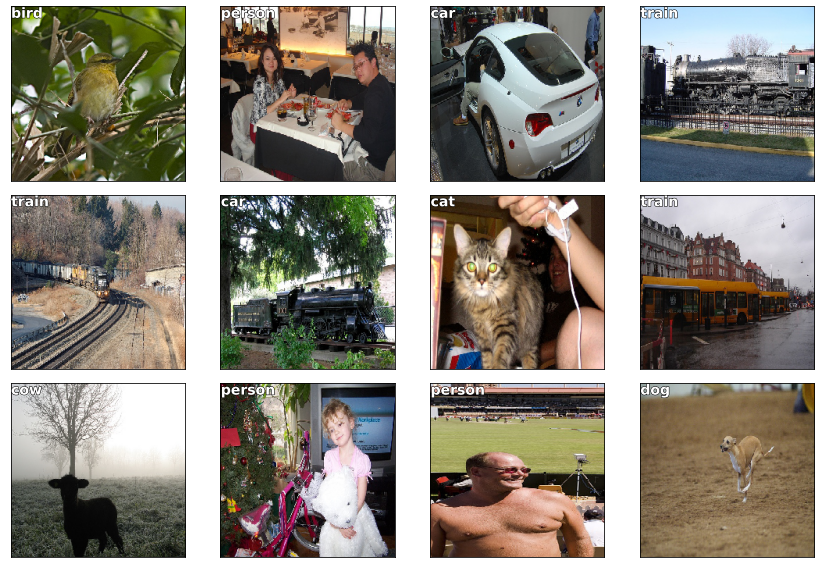

In [24]:


class_name = list(valid_batches.class_indices)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = valid_batches.next()
    image = x[0]
    proba = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)
    class_id = np.argmax(proba)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), class_name[class_id])

plt.tight_layout()

## Step 2: Bbox regression
### 2.1: The Data
Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs.

In [25]:
# we create this time our data frame with the box coordiantes

filename=[]
bbox=[]
for image_id,annotation in annotations.items():
    filename.append(data_filename[image_id])
    bbox.append(get_largest_annotation(annotation)[0])
    
df = pd.DataFrame({'filename': filename, 'bbox': bbox}, columns=['filename','bbox'])

df[:5]

filename                 bbox
0  000012.jpg  [96, 155, 269, 350]
1  000017.jpg   [77, 89, 335, 402]
2  000023.jpg     [1, 2, 461, 242]
3  000026.jpg  [124, 89, 211, 336]
4  000032.jpg  [77, 103, 182, 374]

### create a training and validation set

In [26]:
df_train, df_valid = Split_Train_Valid(df,0.7)

# We cannot use data augmentation anymore!

Unfortunately, we can't really use as before the <kbd>flow_from_dataframe</kbd> function. There are several reasons, but the most important one is that we need to resize the image to fit to our input tensor and as a consequence, bounding boxes should be resized too!, To solve this problem we will  Make our own data generator!

In [27]:

class DataFrame_Generator(keras.utils.all_utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self, df, folder,preprocess_fct,batch_size=32, dim=(32,32), shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder
    
        # Load the dataframe
        # the database is not so big, especially when resized in 224*224.
        # so we have either the option to load images online for each batch or
        # we can load all image at once 
        self.df = df
        self.n = len(df)            
        self.nb_iteration = int(np.floor(self.n  / self.batch_size))
        
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.zeros((self.batch_size,4))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder/self.df['filename'][ID])
            bb = self.df['bbox'][ID]
                 
            # Resize according to the required size
            width, height = img.size
            RatioX = width/self.dim[0]
            RatioY = height/self.dim[1]
                                                        
            img = np.asarray(img.resize(self.dim))
            
            # Resize the bbox accordingly
            bb = [bb[0]/RatioY,bb[1]/RatioX,bb[2]/RatioY,bb[3]/RatioX]
                                 
            # Same as done for VGG16
            X[i,] = self.preprocess_fct(np.asarray(img))
            
            Y[i] = bb

        return X, Y 


In [28]:
train_gen = DataFrame_Generator(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = DataFrame_Generator(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

### 2.2: The model

Here, we want to predict the position of the bounding box.
Actually, we expect our model to predict 4 values: this is a regression problem.

As the difference with Classification, we do not expect a probability but real position values! Our network will be the same as before (especially because we want to share latter the feature encoder part) but instead of adding a classifcation layer with a SoftMax or Sigmoid function (to provide a probability) we only need to add a linear layer

In [29]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
        
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='linear', name='linear')(x)
model = Model(inputs=net.input, outputs=output_layer) 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 2.3: The optimizer

Our optimizer will optimize the task our model is designed for. Compared to before, we used a Cross-entropy as our Loss function to predict Category. Now, as we want to predict continuous values, we are going to use L1 (mean_absolute_error) or L2 Loss (mean_squared_error)

In [30]:
optimizer=Adam(lr=1e-4)

model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 2.4: It's time to train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/15
54/54 [==============================] - 20s 360ms/step - loss: 68.8586 - accuracy: 0.4444 - val_loss: 42.7162 - val_accuracy: 0.5829
Epoch 2/15
54/54 [==============================] - 19s 350ms/step - loss: 41.5165 - accuracy: 0.5758 - val_loss: 39.0122 - val_accuracy: 0.6576
Epoch 3/15
54/54 [==============================] - 19s 351ms/step - loss: 37.2477 - accuracy: 0.6209 - val_loss: 36.9134 - val_accuracy: 0.6780
Epoch 4/15
54/54 [==============================] - 19s 350ms/step - loss: 34.3165 - accuracy: 0.6516 - val_loss: 35.5676 - val_accuracy: 0.6753
Epoch 5/15
54/54 [==============================] - 19s 350ms/step - loss: 31.9816 - accuracy: 0.6730 - val_loss: 34.5745 - val_accuracy: 0.6943
Epoch 6/15
54/54 [==============================] - 19s 354ms/step - loss: 30.4651 - accuracy: 0.6904 - val_loss: 33.9805 - val_accuracy: 0.6970
Epoch 7/15
54/54 [==============================] - 19s 352ms/step - loss: 28.9735 - accuracy: 0.6991 - val_loss: 33.3230 - val_ac

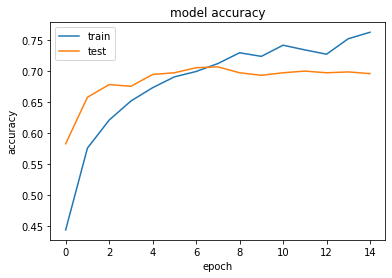

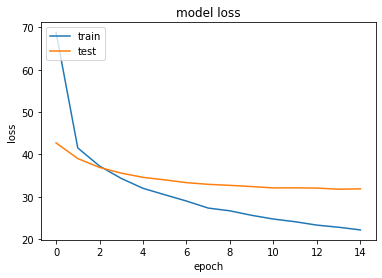

In [31]:
epochs = 15

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2.5: unfreeze couple of layers

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
54/54 [==============================] - 21s 367ms/step - loss: 40.0260 - accuracy: 0.6690 - val_loss: 35.5390 - val_accuracy: 0.7323
Epoch 2/10
54/54 [==============================] - 19s 359ms/step - loss: 28.9274 - accuracy: 0.7106 - val_loss: 28.4611 - val_accuracy: 0.7351
Epoch 3/10
54/54 [==============================] - 19s 361ms/step - loss: 25.8767 - accuracy: 0.7263 - val_loss: 28.8180 - val_accuracy: 0.7432
Epoch 4/10
54/54 [==============================] - 19s 356ms/step - loss: 24.5113 - accuracy: 0.7442 - val_loss: 27.9444 - val_accuracy: 0.7486
Epoch 5/10
54/54 [==============================] - 19s 358ms/step - loss: 21.6789 - accuracy: 0.7419 - val_loss: 27.4625 - val_accuracy: 0.7323
Epoch 6/10
54/54 [==============================] - 19s 358ms/step - loss: 19.8937 - accuracy: 0.7679 - val_loss: 27.0338 - val_accuracy: 0.7500
Epoch 7/10
54/54 [==============================] - 19s 359ms/step - loss: 18.0040 - accuracy: 0.7911 - val_loss: 28.8192 - val_ac

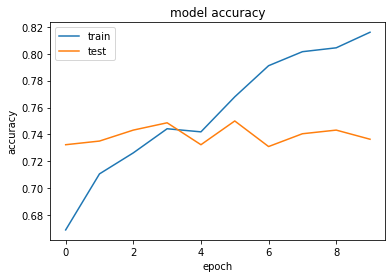

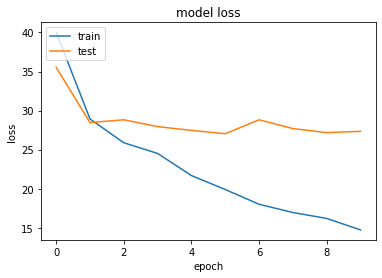

In [32]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
model.compile(optimizer=optimizer,loss='mean_absolute_error', metrics=['accuracy'])    

print(model.summary())

epochs = 10

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

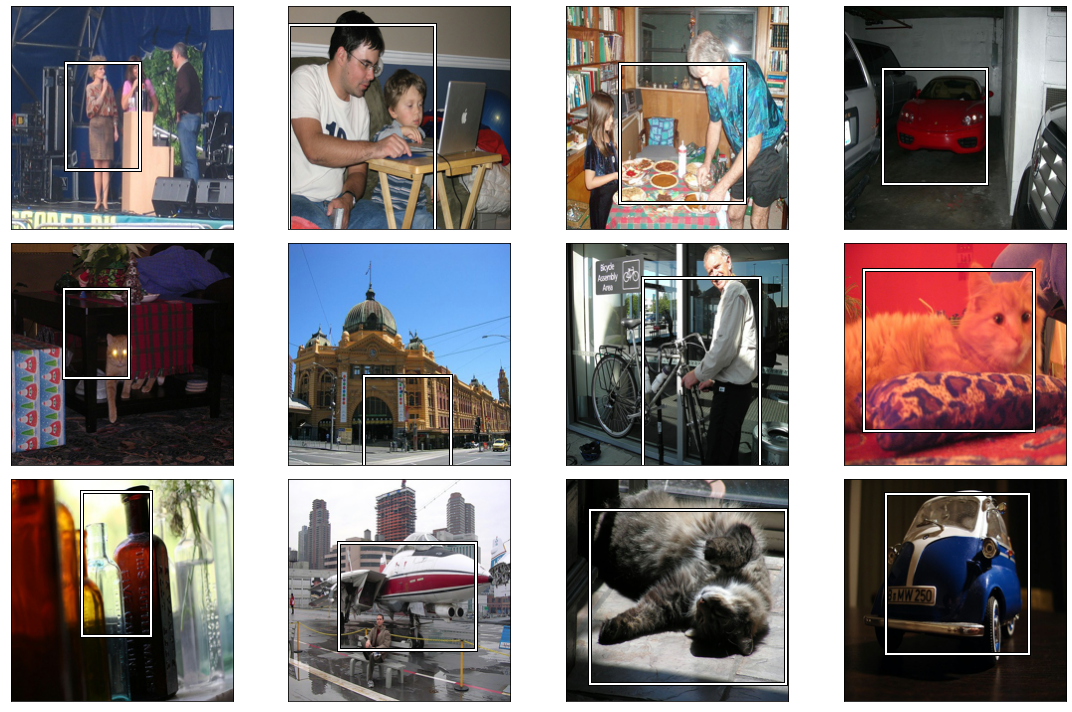

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
for i,ax in enumerate(axes.flat):
    x,y = next(iter(valid_gen))
    image = x[i]
    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb[0]))

plt.tight_layout()

## Step 3: Single object detection

We have now to combine the two individual tasks of classification and detection we have developped bedore. We know that independently, it works. Therefore, if we modify accordingly our data, our model, our Loss function... it should work too!

let's go...

### 3.1: The Data

The data is still the image plus a tuple containing the bounding box coordinates and the category

In [34]:
df = pd.DataFrame({'filename': filename, 'cat':C, 'bbox': bbox}, columns=['filename','cat','bbox'])
df_train, df_valid = Split_Train_Valid(df,0.7)

In [35]:
class GeneratorSingleObject(keras.utils.all_utils.Sequence):
    """Generates data from a Dataframe"""

    def __init__(self, df, folder, preprocess_fct, batch_size=32, dim=(32, 32),
                 shuffle=True):
        'Initialization'
        self.preprocess_fct = preprocess_fct
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.folder = folder
        self.class_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                           'car', 'cat', 'chair',
                           'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                           'person', 'pottedplant', 'sheep',
                           'sofa', 'train', 'tvmonitor']
        self.NbClasses = len(self.class_name)
        self.class_dict = dict(
            (self.class_name[o], o) for o in range(self.NbClasses))

        self.df = df
        self.n = len(df)
        self.nb_iteration = int(np.floor(self.n / self.batch_size))

        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.nb_iteration

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, index):
        """Generates data containing batch_size samples"""
        # Initialization
        # X: (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, 3))
        Y_bb = np.zeros((self.batch_size, 4))
        Y_clas = np.zeros((self.batch_size, 1))

        # Generate data
        for i, ID in enumerate(index):
            # Read the image
            img = Image.open(self.folder / self.df['filename'][ID])
            bb = self.df['bbox'][ID]
            #bb = np.fromstring(bb, dtype=np.int, sep=' ')

            width, height = img.size
            RatioX = width / self.dim[0]
            RatioY = height / self.dim[1]

            img = np.asarray(img.resize(self.dim))
            bb = [bb[0] / RatioY, bb[1] / RatioX, bb[2] / RatioY, bb[3] / RatioX]

            X[i] = self.preprocess_fct(np.asarray(img))
            Y_bb[i] = bb
            Y_clas[i] = self.class_dict[self.df['cat'][ID]]

        Y_clas = keras.utils.all_utils.to_categorical(Y_clas, self.NbClasses)

        return X, [Y_bb,Y_clas]




In [36]:
train_gen = GeneratorSingleObject(df_train,JPEGS,preprocess_input,bs,(sz,sz),True)
valid_gen = GeneratorSingleObject(df_valid,JPEGS,preprocess_input,bs,(sz,sz),False)

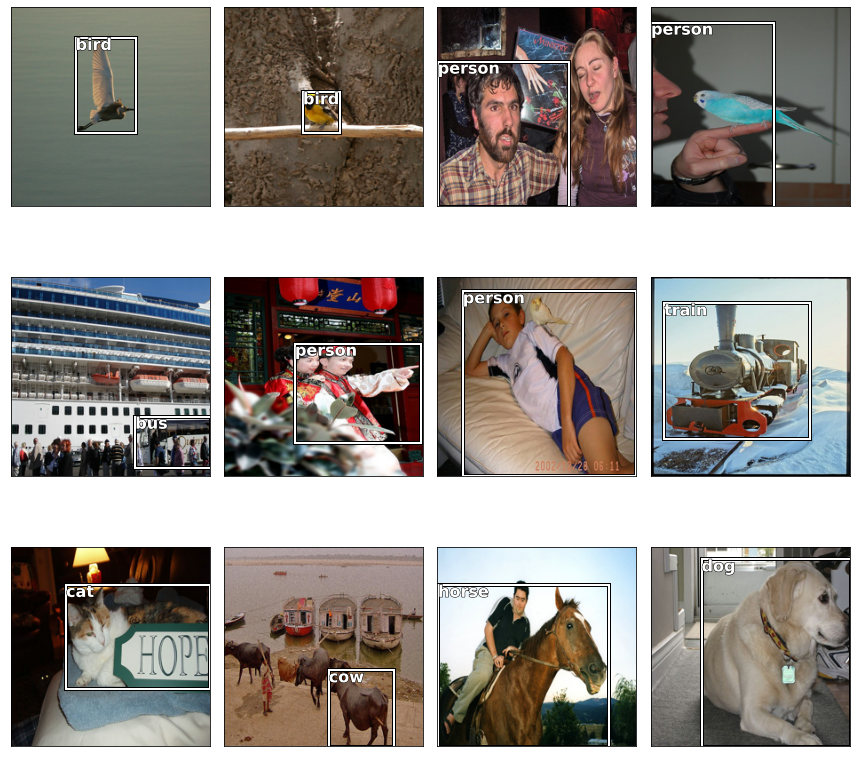

In [37]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(valid_gen))
    bb = y_batch[0][i]
    cat = y_batch[1][i]    
    image = x_batch[i]

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

### 3.2: The model

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

Notice, the importance of Keras functional API. With sequential API, this multi-output model is not possible.

In [38]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False
 
y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)

# branch for the regression --> BBox
output_layer_bbox = Dense(4, activation='linear', name='layer_bbox')(y)

# Branch for the classification --> Category
output_layer_class = Dense(train_gen.NbClasses, activation='softmax', name='layer_class')(y)

model = Model(inputs=net.input, outputs=[output_layer_bbox,output_layer_class])

### 3.3: The optimizer

Here, we need to combine the two Loss function for each branch.
Because each Loss will have different range, it is then better to set a weight on each of them.
We can check from the previous individual training to put the weight accordingly so that each branch has the same influence

In [39]:
optimizer=Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], metrics=['accuracy'],loss_weights=[1., 5.])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 3.4: Time to train

In [40]:
epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

print(history.history.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
27/27 [==============================] - 29s 714ms/step - loss: 216.9759 - layer_bbox_loss: 81.6776 - layer_class_loss: 27.0597 - layer_bbox_accuracy: 0.4346 - layer_class_accuracy: 0.1748 - val_loss: 106.8514 - val_layer_bbox_loss: 50.0935 - val_layer_class_loss: 11.3516 - val_layer_bbox_accuracy: 0.5355 - val_layer_class_accuracy: 0.3821
Epoch 2/20
27/27 [==============================] - 19s 700ms/step - loss: 115.1339 - layer_bbox_loss: 45.7678 - layer_class_loss: 13.8732 - layer_bbox_accuracy: 0.5341 - layer_class_accuracy: 0.4074 - val_loss: 82.8080 - val_layer_bbox_loss: 42.5788 - val_layer_class_loss: 8.0458 - val_layer_bbox_accuracy: 0.5781 - val_layer_class_accuracy: 0.5455
Epoch 3/20
27/27 [==============================] - 19s 701ms/step - loss: 85.9629 - layer_bbox_loss: 41.3041 - layer_class_loss: 8.9318 - layer_bbox_accuracy: 0.5758 - layer_class_accuracy: 0.5440 - val_loss: 73.9167 - val_layer_bbox_loss: 39.4389 - val_layer_class_loss: 6.8956 - val_layer_bbox

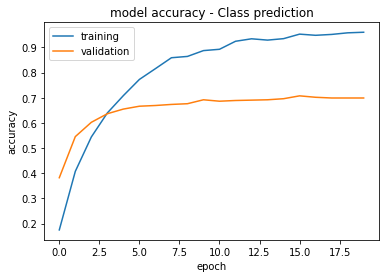

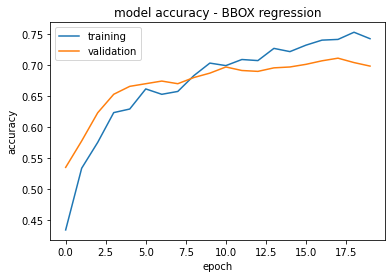

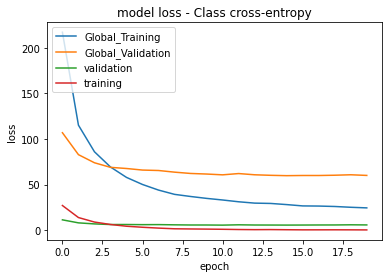

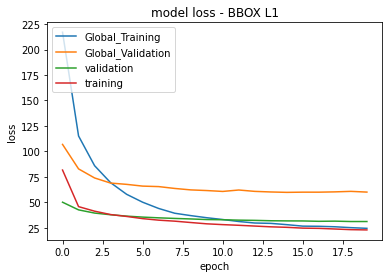

In [41]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_accuracy'])
plt.plot(history.history['val_layer_bbox_accuracy'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

### 3.5: unfreeze few layers

In [42]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
optimizer=Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss=['mean_absolute_error','categorical_crossentropy'], 
              metrics=['accuracy'],loss_weights=[1., 20.])
 

epochs = 20

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,
                              epochs = epochs,
                              validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
27/27 [==============================] - 21s 733ms/step - loss: 27.3568 - layer_bbox_loss: 22.3377 - layer_class_loss: 0.2510 - layer_bbox_accuracy: 0.7465 - layer_class_accuracy: 0.9659 - val_loss: 148.1601 - val_layer_bbox_loss: 30.9154 - val_layer_class_loss: 5.8622 - val_layer_bbox_accuracy: 0.7003 - val_layer_class_accuracy: 0.6974
Epoch 2/20
27/27 [==============================] - 19s 710ms/step - loss: 27.2369 - layer_bbox_loss: 22.0565 - layer_class_loss: 0.2590 - layer_bbox_accuracy: 0.7517 - layer_class_accuracy: 0.9659 - val_loss: 145.9358 - val_layer_bbox_loss: 30.7431 - val_layer_class_loss: 5.7596 - val_layer_bbox_accuracy: 0.7159 - val_layer_class_accuracy: 0.7088
Epoch 3/20
27/27 [==============================] - 19s 724ms/step - loss: 27.3216 - layer_bbox_loss: 21.6466 - layer_class_loss: 0.2837 - layer_bbox_accuracy: 0.7639 - layer_class_accuracy: 0.9711 - val_loss: 146.1649 - val_layer_bbox_loss: 30.6464 - val_layer_class_loss: 5.7759 - val_layer_bbox_ac

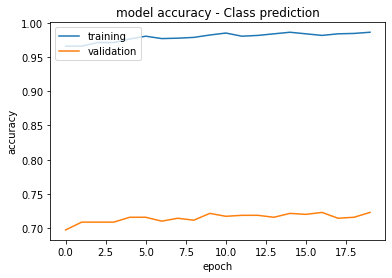

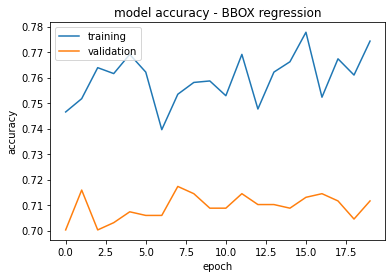

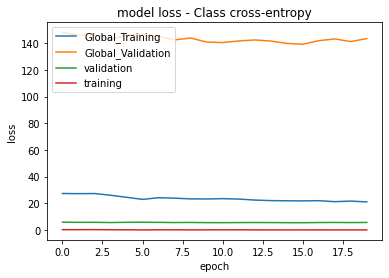

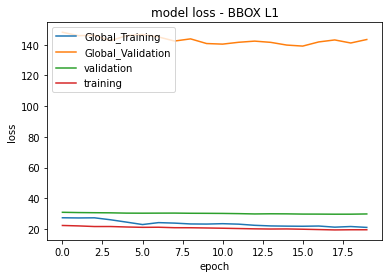

In [43]:
# summarize history for accuracy for Class
plt.plot(history.history['layer_class_accuracy'])
plt.plot(history.history['val_layer_class_accuracy'])
plt.title('model accuracy - Class prediction')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for accuracy for bbox regression
plt.plot(history.history['layer_bbox_accuracy'])
plt.plot(history.history['val_layer_bbox_accuracy'])
plt.title('model accuracy - BBOX regression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

# summarize history for loss for Class
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_class_loss'])
plt.plot(history.history['layer_class_loss'])
plt.title('model loss - Class cross-entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

# summarize history for loss for BBOX
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_layer_bbox_loss'])
plt.plot(history.history['layer_bbox_loss'])
plt.title('model loss - BBOX L1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Global_Training', 'Global_Validation','validation','training'], loc='upper left')
plt.show()

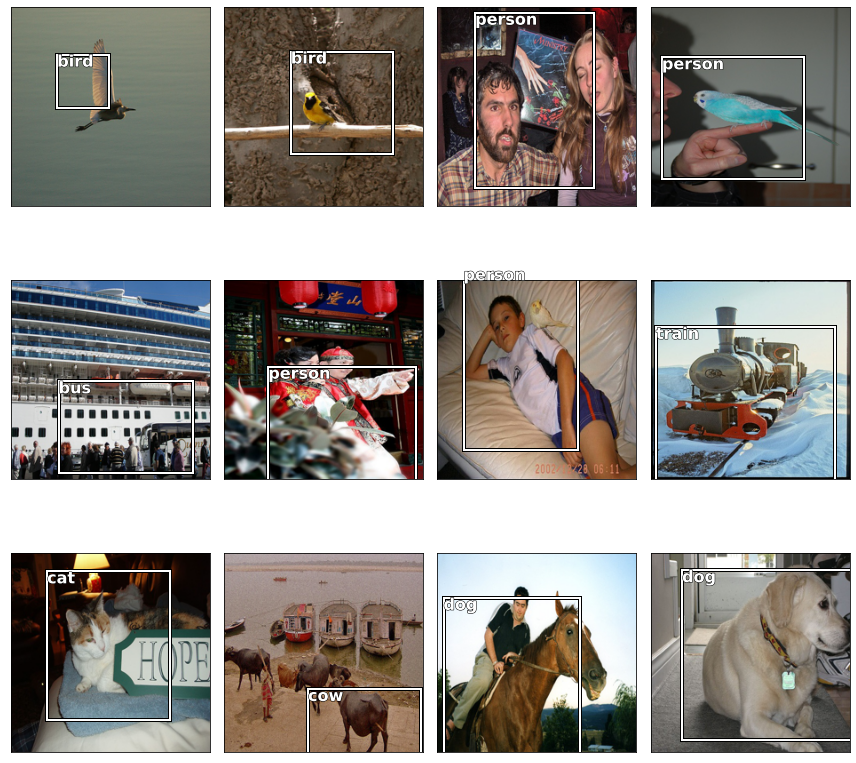

In [76]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(iter(valid_gen)))
    image = x_batch[i]
    model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)

    bb = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)[0][0]
    cat =model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)[1][0]   
    

    c = np.argmax(cat)
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_rect(ax, bb_hw(bb))
    draw_text(ax, [bb[1],bb[0]], train_gen.class_name[c], sz=16)

plt.tight_layout()

###Later we will enhance this model and use advanced techniques ex. yolo v4  to infer real time images